# **WhatsApp Group Chat Analysis by Sai Krishna Reddy Koppula**

# The first step of a Data Analysis Project - Define the problem statement

It was during one of our routine chit chat sessinos when my friend claimed that he was the 'unsung hero' of our WhatsApp group, constantly texting to keep the conversation alive.

Curious to see if his claim was true, we started examining our chat logs. During this process, I noticed the extensive use of emojis in our conversations. Emojis have become so integral to our digital interactions that I began to wonder how much they truly impact the way we communicate.

That's when I recalled a discussion with my seniors about analyzing group chats to uncover user engagement for a project they were working on. Inspired by their idea, curious about the role of emojis in our digital conversations, and admittedly wanting to see if my friend's claim held up, I decided to dive into the data of my own WhatsApp group.

# The second step of a Data Analysis Project - Collet and Store Data

To collect the chat needed for my analysis, I have used the whatsapp chat export feature. This feature allowed me to extract the chat in the form of a zip file. once I have extracted this sip file, I was left with a .txt file which I could use for my data analysis.


# The thrid step of a Data Analysis Project - Process, Clean and Prepare Data

After collecting the chat data from WhatsApp, I began processing and cleaning it to ensure accurate analysis. This involved parsing the raw .txt file to extract relevant information such as date, time, author, and message content. I handled inconsistencies in formatting and filtered out non-message lines like timestamps and notifications. Each message was then categorized and stored in a structured format within a pandas DataFrame. This meticulous data cleaning process was crucial to transforming the unstructured chat logs into a clean, analyzable dataset, ready for further exploration and visualization.

In [ ]:
!pip install emoji # installing emoji package so that we can work with the emoji's in the chat

In [ ]:
#importing all reqirement packages for my data cleaning and analysis
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
import datetime
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#% matplotlib inline

**DATA PREPARATION** :
Let's take a single line from the chat log (which can be referred to as "raw text") and break it down into four key components:

***{Date}, {Time} - {Author}: {Message}***

**Example:**

raw_text = '[09/12/19, 8:49:53 PM] User1: How are you?'

This should be broken down into: ***{09/12/19}, {8:49:53 PM} - {User1}: {How are you?}***



In [ ]:
def startsWithDateAndTime(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])[ ]?(AM|PM|am|pm)?\]'
    result = re.match(pattern, s)
    if result:
        return True
    return False

# This function is to identify if the line we are reading starts with a Date and Time or not

In [ ]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',
        '([\w]+[-]+[\w]+):',               # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '(([\w+\s*])+[@]+[\s*+\w*+#*]+):', # First Name + Last Name + @
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

#Once you identify that a line starts with a Date and Time, it is important to identify the Authour of the message.
#This funtion with the help of regular expressions helps you to identify the Author of the message.

In [ ]:
def getDataPoint(line):
    #print("Line : ",line)
    splitLine = line.split('] ')
    #print("SplitLine : ",splitLine)
    dateTime = splitLine[0]
    #print("Date Tine : ",dateTime)
    if ',' in dateTime:
      date, time = dateTime.split(',')
    else:
      date, time = dateTime.split(' ')
    date = date[1:]
    time = time[1:]
    #print("Date : ",date,"   Time : ",time)
    message = ' '.join(splitLine[1:])
    #print("Message : ",message)
    if FindAuthor(message):
        splitMessage = message.split(': ')
        #print("Hello")
        #print(splitMessage)
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

#This is the main funtion to tokenize your message

In [ ]:
getDataPoint("[09/12/19, 8:49:53 PM] User1: How are you?")

('09/12/19', '8:49:53 PM', 'User1', 'How are you?')

Now that we have a tokenize function ready, I am going to read line by line from the file and tokenize each line and store the data in a dataframe. I am going to make necessary transformations to the data as I read it from teh file to ensure that it is consistent and functions work appropriately.

In [ ]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '__________________________________'   #upload the file an copy paste the path here

In [ ]:
with open(conversationPath,'r') as file:
    data = file.read()
    data = data.replace('\u202f','')

with open(conversationPath,'w') as file:
    file.write(data)

In [ ]:
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline() #skipping this line because it contains info about who created the grp
    #fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if startsWithDateAndTime(line):
            if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPoint(line)
            messageBuffer.append(message)
        else:
          line= (line.encode('ascii', 'ignore')).decode("utf-8")
          if startsWithDateAndTime(line):
            if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPoint(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

In [ ]:
def dateconv(date):    #Converting date from DD-MM-YY or DD-MM-YYYY format to YYYY-MM-DD fromat
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "%m-%d-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "%m-%d-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "%m/%d/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "%m/%d/%y").strftime("%Y-%m-%d")

By now, I have stored all the messages as a list of lists in the variable **parsedData**. I am now going to convert it into a dataframe to further use it for my analysis.

In [ ]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = df["Date"].apply(dateconv)
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1542 entries, 0 to 1541
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1542 non-null   datetime64[ns]
 1   Time     1542 non-null   object        
 2   Author   1541 non-null   object        
 3   Message  1542 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 48.3+ KB


In [ ]:
df = df.dropna() #removing those messages that do no have authors i.e they are generated by whatsapp like change of grp descriptoion etc
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, 1 to 1541
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1541 non-null   datetime64[ns]
 1   Time     1541 non-null   object        
 2   Author   1541 non-null   object        
 3   Message  1541 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 60.2+ KB


My dataframe is complete ready with all the required data in a clean format. now let's proceed to the next step.

In [ ]:
list_of_authors = df.Author.unique()
new_list_of_authors = []
for i in range(len(list_of_authors)):
  new_list_of_authors.append("User" + str(i+1))
#Performing this action to ensure that the names of the users are private when I am displaying my results

for i in range(len(list_of_authors)):
  df = df.replace(list_of_authors[i], new_list_of_authors[i])

list_of_authors = df.Author.unique()
print(list_of_authors) # I am creating a list of all the authors in the chat

['User1' 'User2' 'User3' 'User4' 'User5' 'User6' 'User7' 'User8' 'User9']


In [ ]:
total_messages = df.shape[0]
print("Total Messages : ",total_messages)
media_messages = df[df['Message'] == 'image omitted'].shape[0]
print("Media messages : ",media_messages)
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

Total Messages :  1541
Media messages :  23


In [ ]:
def emoji_find(text):
    emoji_list = []
    data = regex.findall(r'\X',text)
    for word in data:
      if any(char in emoji.EMOJI_DATA for char in word):
        emoji_list.append(word)
    return emoji_list

df["emoji"] = df["Message"].apply(emoji_find)

df.head(10)

,Date,Time,Author,Message,urlcount,emoji
1,2019-12-17,5:19:48AM,User1,Arey,0,[]
2,2019-12-17,5:20:01AM,User1,Rooms studio type adagala,0,[]
3,2019-12-17,5:20:02AM,User2,Bolo,0,[]
4,2019-12-17,5:20:08AM,User1,Like 3 bedroom flat,0,[]
5,2019-12-17,5:20:09AM,User1,Ala,0,[]
6,2019-12-17,5:20:33AM,User1,Anni untaayi fridge cooking things,0,[]
7,2019-12-17,5:20:34AM,User1,Anni,0,[]
8,2019-12-17,5:20:56AM,User3,Haa adhi Oka flat masth aithadhi🙌,0,[🙌]
9,2019-12-17,5:21:01AM,User1,Manam 5 nights ki Andukey,0,[]
10,2019-12-17,5:21:36AM,User2,Best set,0,[]


# The fourth step of a Data Analysis Project - Analyse Data

Let us look at some general statistics before we get into answering our questions

**GROUP STATS :**

In [ ]:
total_messages = df.shape[0]
print("Total Messages : ",total_messages)
media_messages = df[df['Message'] == 'image omitted'].shape[0]
print("Media messages : ",media_messages)
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)
print("Total Links : ",links)
emojis = np.sum(df.emoji)
total_count_of_emojis = len(emojis)
print("No of emojis used : ",total_count_of_emojis)

Total Messages :  1541
Media messages :  23
Total Links :  12
No of emojis used :  307


Now, let's divide text messages and media messages into different data frames

In [ ]:
media_messages_df = df[(df['Message'] == 'image omitted')|(df['Message'] == 'video omitted')]
sticker_messages_df = df[df['Message'] == 'sticker omitted']
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(sticker_messages_df.index)
#messages_df.head(10)
#media_messages_df.head(10)
#sticker_messages_df.head(10)

In [ ]:
messages_df["Letter_count"] = messages_df["Message"].apply(lambda s : len(s))
messages_df["Word_count"] = messages_df["Message"].apply(lambda s : len(s.split(" ")))
messages_df["MessageCount"]=1

**Author** **Wise** **stats** :

In [ ]:
# Creates a list of unique Authors
l = messages_df.Author.unique()

print(l)

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print("Stats of :",l[i])
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  #sticker conists of stickers messages
  stickers = sticker_messages_df[sticker_messages_df['Author'] == l[i]].shape[0]
  print('Sticker Messages Sent', stickers)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])
  print('Links Sent', links)
  print()

['User1' 'User2' 'User3' 'User4' 'User5' 'User6' 'User7' 'User8' 'User9']
Stats of : User1
Messages Sent 541
Words per message 3.9833641404805915
Media Messages Sent 11
Sticker Messages Sent 1
Emojis Sent 95
Links Sent 4

Stats of : User2
Messages Sent 93
Words per message 3.225806451612903
Media Messages Sent 0
Sticker Messages Sent 0
Emojis Sent 12
Links Sent 0

Stats of : User3
Messages Sent 29
Words per message 3.8275862068965516
Media Messages Sent 0
Sticker Messages Sent 0
Emojis Sent 11
Links Sent 0

Stats of : User4
Messages Sent 359
Words per message 2.3008356545961
Media Messages Sent 2
Sticker Messages Sent 0
Emojis Sent 65
Links Sent 0

Stats of : User5
Messages Sent 126
Words per message 5.666666666666667
Media Messages Sent 9
Sticker Messages Sent 1
Emojis Sent 39
Links Sent 0

Stats of : User6
Messages Sent 25
Words per message 2.44
Media Messages Sent 0
Sticker Messages Sent 0
Emojis Sent 6
Links Sent 0

Stats of : User7
Messages Sent 171
Words per message 3.43274853801

Let us get into a detailed analysis of different emoji's used in the chat

**Emoji Stats :**

In [ ]:
#TOTAL UNIQUE EMOJIS USED IN THE GRP
different_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
different_emojis_count = len(different_emojis_list)
print("Count of different emojis used in the grp : ",different_emojis_count)


Count of different emojis used in the grp :  55


In [ ]:
total_emojis = [a for b in messages_df.emoji for a in b]
emoji_and_its_count = Counter(total_emojis)
emoji_and_its_count_dict_sorted = sorted(emoji_and_its_count.items(), key=lambda x: x[1], reverse=True)
print(emoji_and_its_count_dict_sorted)

[('😂', 146), ('🔥', 20), ('🤣', 19), ('🥴', 15), ('😬', 9), ('🤘🏻', 5), ('😅', 5), ('😝', 5), ('🤦\u200d♂', 4), ('🙄', 4), ('🥂', 4), ('🥺', 4), ('🤨', 3), ('💸', 3), ('😴', 3), ('🙋🏻\u200d♂️', 3), ('🤟🏻', 3), ('👍', 2), ('🤧', 2), ('😖', 2), ('😒', 2), ('🤙', 2), ('✌', 2), ('🥰', 2), ('🚬', 2), ('🐒', 2), ('💨', 2), ('🕷', 2), ('🤦🏻\u200d♂️', 2), ('‼️', 2), ('🤔', 2), ('🙌', 1), ('🌊', 1), ('🏖', 1), ('💥', 1), ('😁', 1), ('🤤', 1), ('🤪', 1), ('✋🏻', 1), ('🤟', 1), ('🙌🏻', 1), ('💯', 1), ('🤐', 1), ('🤕', 1), ('😑', 1), ('🙂', 1), ('😓', 1), ('😉', 1), ('🤮', 1), ('✌🏻', 1), ('🤭', 1), ('🧐', 1), ('🐶', 1), ('✨', 1), ('😋', 1)]


In [ ]:
emoji_df = pd.DataFrame(emoji_and_its_count_dict_sorted,columns=['emoji','count'])
emoji_df

,emoji,count
0,😂,146
1,🔥,20
2,🤣,19
3,🥴,15
4,😬,9
5,🤘🏻,5
6,😅,5
7,😝,5
8,🤦‍♂,4
9,🙄,4


In [ ]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

**Person Wise Emoji Distribution :**

In [ ]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for User1


Emoji Distribution for User2


Emoji Distribution for User3


Emoji Distribution for User4


Emoji Distribution for User5


Emoji Distribution for User6


Emoji Distribution for User7


Emoji Distribution for User8


Emoji Distribution for User9


**Day Wise distribution : **

In [ ]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [ ]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

Number of messages as times move on

In [ ]:
messages_df.head(10)

,Date,Time,Author,Message,urlcount,emoji,Letter_count,Word_count,MessageCount
1,2019-12-17,5:19:48AM,User1,Arey,0,[],4,1,1
2,2019-12-17,5:20:01AM,User1,Rooms studio type adagala,0,[],25,4,1
3,2019-12-17,5:20:02AM,User2,Bolo,0,[],4,1,1
4,2019-12-17,5:20:08AM,User1,Like 3 bedroom flat,0,[],19,4,1
5,2019-12-17,5:20:09AM,User1,Ala,0,[],3,1,1
6,2019-12-17,5:20:33AM,User1,Anni untaayi fridge cooking things,0,[],34,5,1
7,2019-12-17,5:20:34AM,User1,Anni,0,[],4,1,1
8,2019-12-17,5:20:56AM,User3,Haa adhi Oka flat masth aithadhi🙌,0,[🙌],33,6,1
9,2019-12-17,5:21:01AM,User1,Manam 5 nights ki Andukey,0,[],25,5,1
10,2019-12-17,5:21:36AM,User2,Best set,0,[],8,2,1


In [ ]:
start_date = pd.to_datetime('01/01/2020')
end_date = pd.to_datetime('01/20/2020')
auth = messages_df.groupby(["Author", "Date"]).sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Date", x="MessageCount", color='Author', orientation="h",
             title="Explicit color sequence"
             ,range_y = [start_date, end_date]
             ,barmode='group'
            )
fig.show()

**When are the group members most active?**

Text(0, 0.5, 'Time')

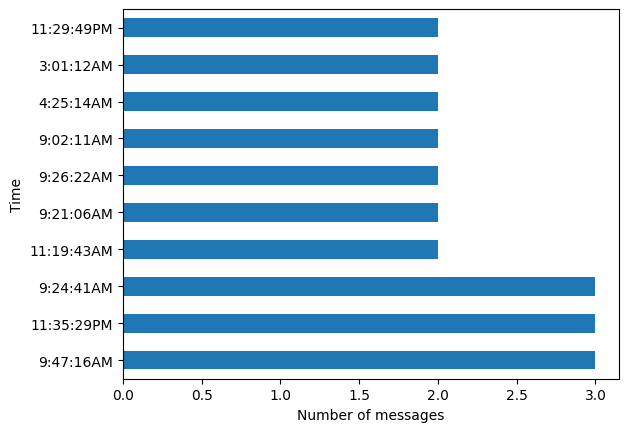

In [ ]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

**Most Happening Day was :**

Date
2020-01-03    245
2020-01-08    160
2020-01-04    152
2019-12-28    111
2019-12-29     96
2020-01-07     94
2020-01-06     81
2019-12-21     72
2019-12-27     56
2019-12-26     53
2020-01-09     52
2020-01-14     50
2019-12-17     45
2020-01-11     41
2019-12-19     39
2020-02-01     37
2020-01-02     35
2020-01-05     31
2020-01-15     24
2020-01-13     12
2019-12-25      7
2020-01-12      4
2020-01-16      4
2020-01-01      3
2020-05-03      1
2021-12-22      1
2022-06-17      1
Name: count, dtype: int64


Text(0, 0.5, 'Date')

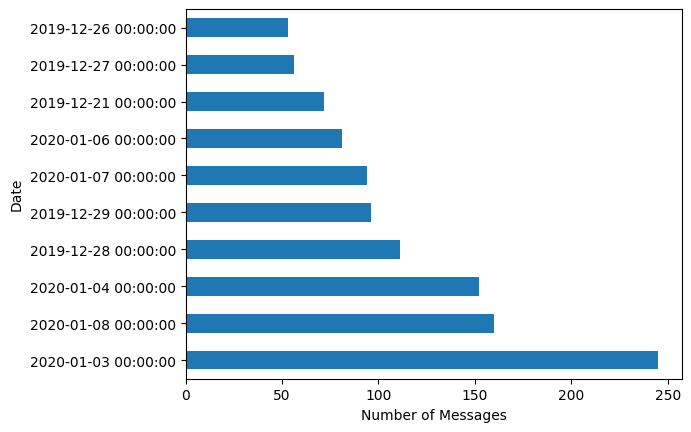

In [ ]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

**Word Cloud :**

In [ ]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 33100 words in all the messages.


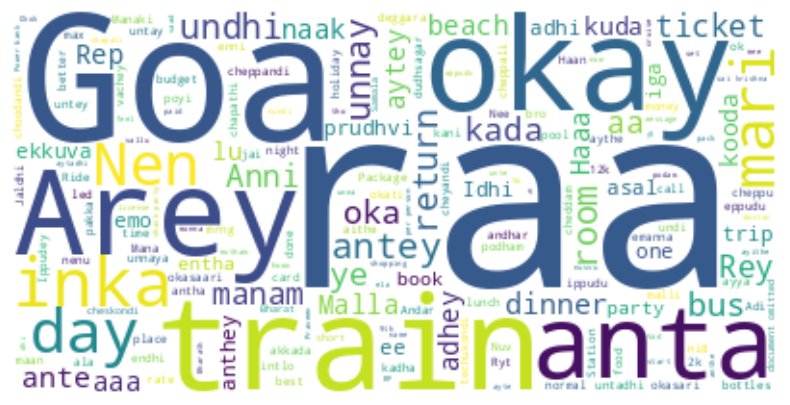

In [ ]:
stopwords = set(STOPWORDS)
stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah", "ha", "la", "eh", "ne", "le", "ni", "lo", "Ma", "Haa", "ni"])
#Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:

plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# # The last(fifth) step of a Data Analysis Project - Present the Insights & Results

### Initial Results

Now that we have explored various statistics and analytics of the chat, let's address our main objective: was my friend truly the unsung hero of the group?

In [ ]:
messages_trimmed_df = messages_df.drop(columns=['Letter_count', 'Word_count', 'urlcount', 'emoji','Time'])


messages_per_author = messages_trimmed_df.groupby('Author')['MessageCount'].sum()
max_messages_author = max(messages_per_author)
print("Author with the most number of messages:")
print(messages_per_author[messages_per_author == max_messages_author])

Author with the most number of messages:
Author
User1    541
Name: MessageCount, dtype: int64


From the above results, it can be concluded that User1 (my friend in this case) sent the highest number of messages. Seeing this, my friend was very excited that his claim was true. However, this made me ponder further: **Does sending the most messages really mean he was the most frequently active? What do you think?**

### Let's think further!!!

I don't think I can say that my friend is the most active member of the group, just because he has sent the highest number of messages. I think that most active member of the group is the one who has engaged highly on most number of days rather than just having a total highest. Let's see how we can find that!

In [ ]:
#messages_trimmed_df = messages_df.drop(columns=['Letter_count', 'Word_count', 'urlcount', 'emoji','Time'])
#created a trimmed data set for making further detailed analysis
#Q: Who is mostly active on most number of days
#messages_trimmed_df.head(10)

grouped = messages_trimmed_df.groupby(['Date','Author']).sum().reset_index()

# Find the author with the highest number of messages each day
top_authors_per_day = grouped.loc[grouped.groupby('Date')['MessageCount'].idxmax()]

# Count the number of days each author was the top contributor
top_days_count = top_authors_per_day['Author'].value_counts()

# Identify the author with the most top contributor days
most_top_contributor_days = top_days_count.idxmax()
most_top_contributor_count = top_days_count.max()

print("Author with the most number of top contributor days:")
print(f"{most_top_contributor_days} with {most_top_contributor_count} days")


Author with the most number of top contributor days:
User1 with 14 days


# **Final Results**

**In the final step of our analysis, I discovered that User1 (my friend) not only sent the highest number of messages overall but also had the most days with the highest message count. It was only after seeing these results that I agreed his claim was true.**

This highlights the importance of determining your metrics carefully. Selecting the right metrics is crucial because it directly influences the accuracy and relevance of your analysis. Without the right metrics, you might miss key insights or draw incorrect conclusions. For instance, merely counting the total number of messages would not have fully captured User1's engagement pattern; we needed to also consider the number of days he was the top contributor to understand his consistent activity. The right metrics help you to measure what truly matters and provide a clear, comprehensive picture of the situation, leading to more informed and reliable conclusions. This precision is essential in any data-driven decision-making process, ensuring that the insights you gain are both actionable and meaningful.